In [7]:
import sys
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
from scipy.stats import pearsonr
from itertools import combinations

In [2]:
def get_config(file):
    """
    Read in config file and return it as a dictionary.
    
    :parameter
    ----------
    file - str
        Configuration file in yaml format

    :returns
    --------
    config - dict
        Configuration file in dictionary form.
    """
    if not file.exists():
        raise FileExistsError(f"The file that was supplied does not exists: {file}")

    with open(file, 'r') as stream:
        config = yaml.safe_load(stream)

    return config

In [3]:
config = get_config(Path("config.yaml"))

In [4]:
results_fisher = {}

for trait, info in config["results_fisher"].items():
    results_fisher[trait] = []
    for method, file in info.items():
        df = pd.read_csv(file, sep="\t")
        df.drop(columns=df.columns[0], inplace=True)
        results_fisher[trait].append((method, df))

# Compare the result of the fisher exact tests for a variety of different HPO terms. 

In [5]:
def plot_comparison_fisher_results(trait_data, trait) -> None:
    """
    Numerous fisher exact tests were done using different HPO terms on the result on various
    gene prioritization methods.
    
    This function visualizes the comparison of these results and by doing so it 
    creates an overview of how similar/disimilar the different gene prioritization methods
    performed.
    
    :parameters
    -----------
    trait_data - list<tuple>
        A list with tuples containing the name of the gene prioritization method and their results
        for a specific trait (e.g. height, IBD, or prostate cancer)
    trait - str
        Name of the GWAS trait that was originally used.
    """

    plt.figure(figsize=(20, 22))

    for i, (method1, method2) in enumerate(combinations(trait_data,2)):
        plt.subplot(4, 3, i+1)
        trait_index = method1[1]["GWAS trait"].str.lower() == trait.lower()

        x = method1[1][~trait_index].zscores
        y = method2[1][~trait_index].zscores

        x_hpo = method1[1][trait_index].zscores
        y_hpo = method2[1][trait_index].zscores
        plt.scatter(x, y)
        plt.scatter(x_hpo, y_hpo, c='red', label="HPO term")

        hpo_id = method1[1][trait_index]["HPO ID"].values[0]

        plt.text(x_hpo, y_hpo, hpo_id)
        plt.title(f"{method1[0]} - {method2[0]}")
        plt.xlabel(f"{method1[0]} zscore(p-values)"); plt.ylabel(f"{method2[0]} zscore(p-values)")
        plt.legend(loc="upper right")

    plt.show()

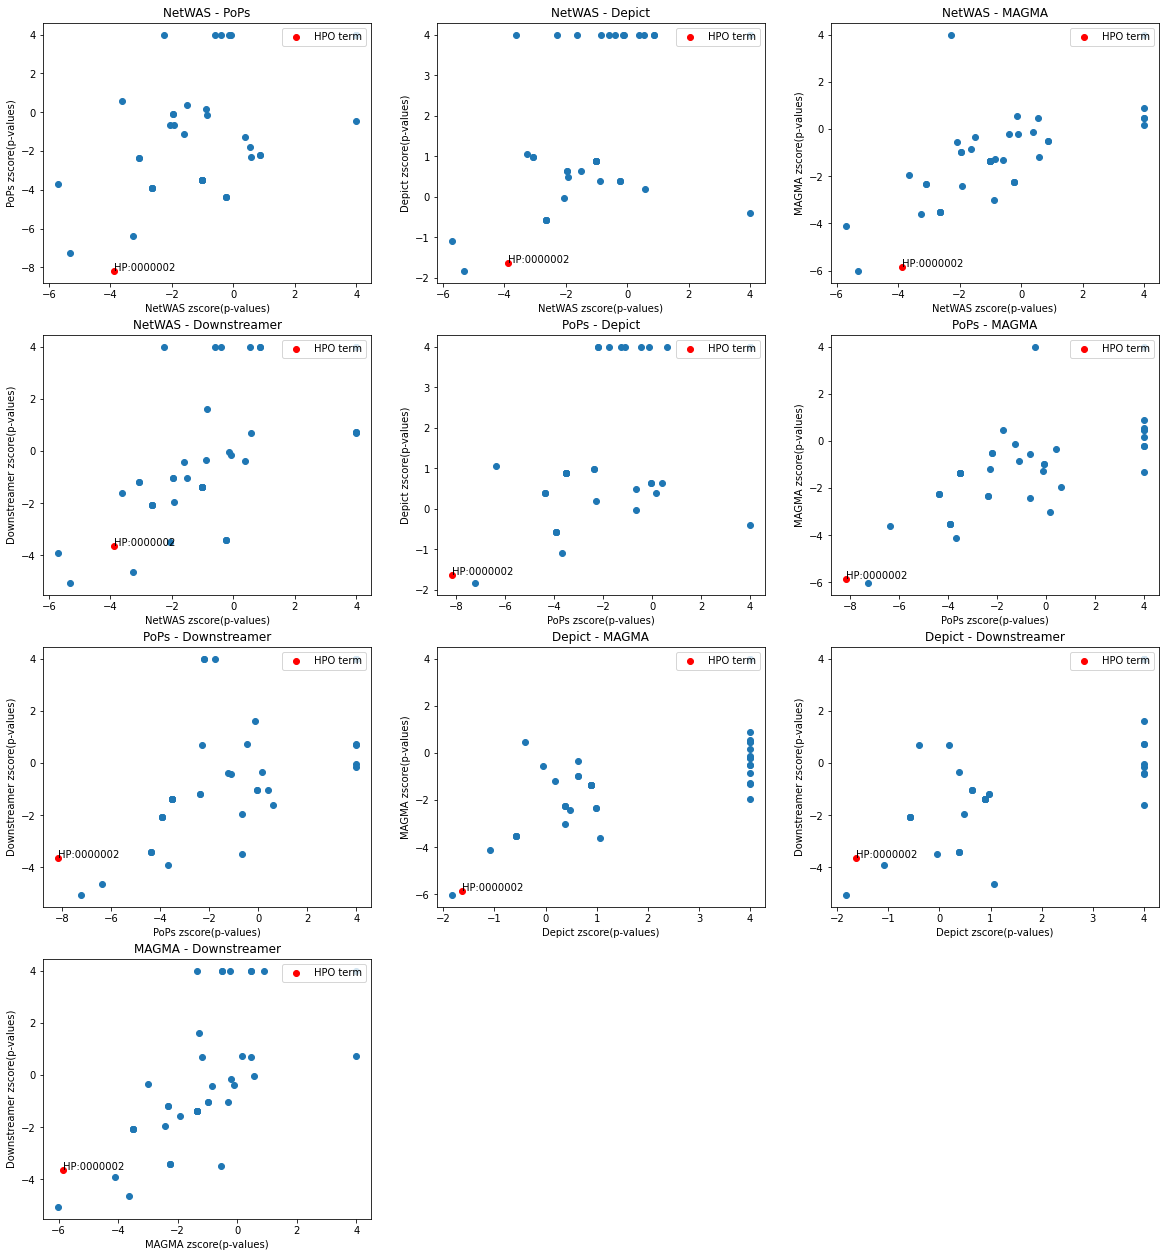

In [6]:
plot_comparison_fisher_results(results_fisher['Height'], 'height')

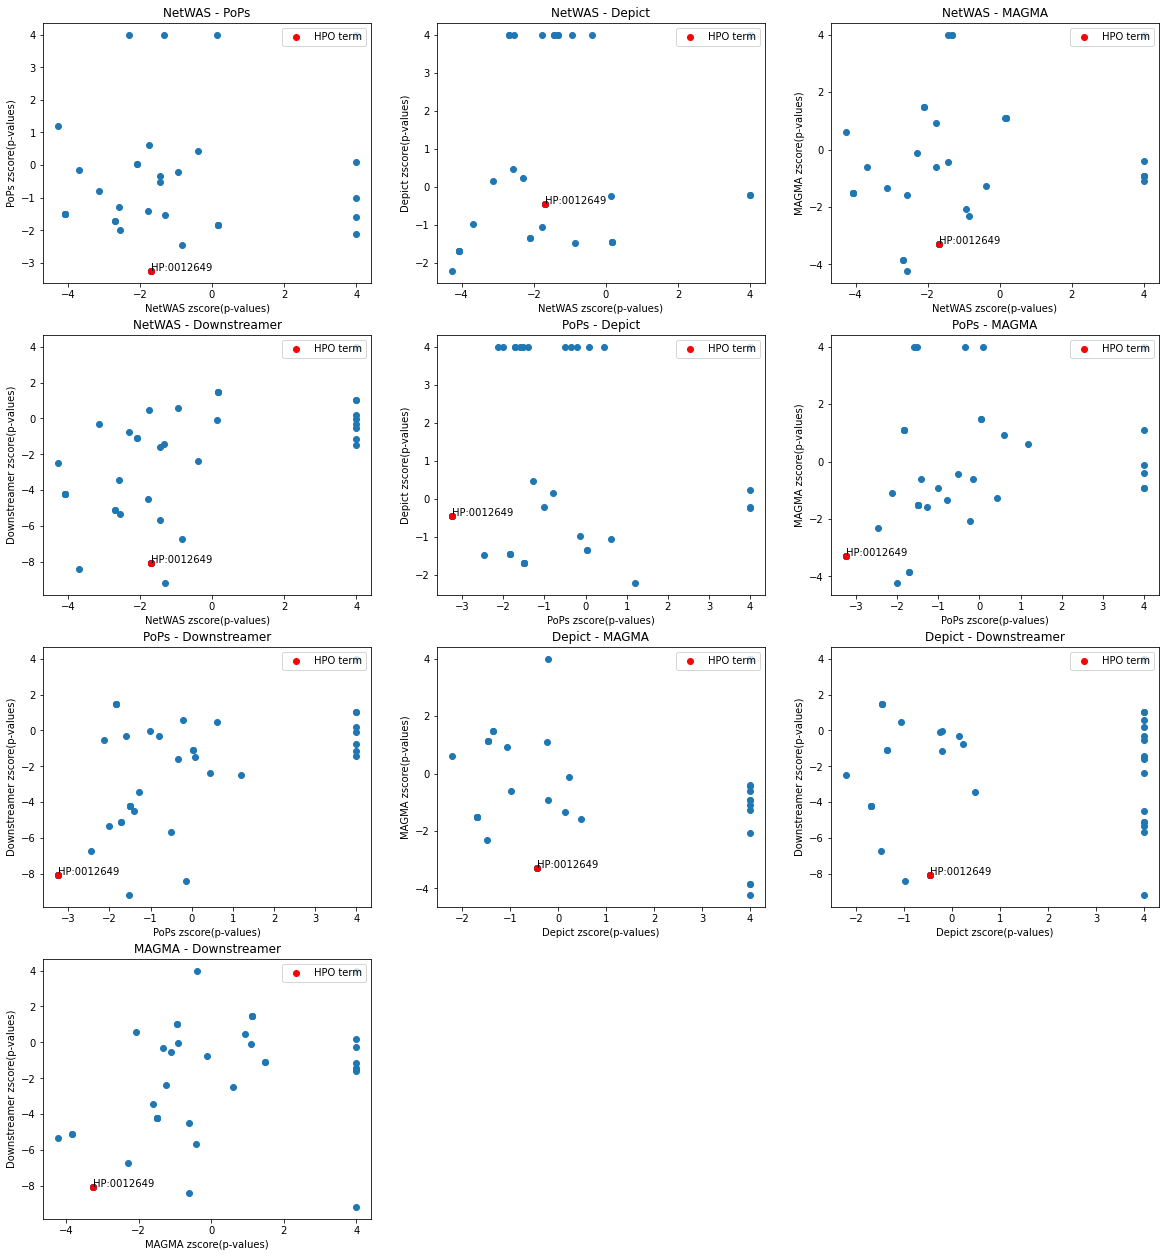

In [7]:
plot_comparison_fisher_results(results_fisher['IBD'], "inflammatory bowel disease")

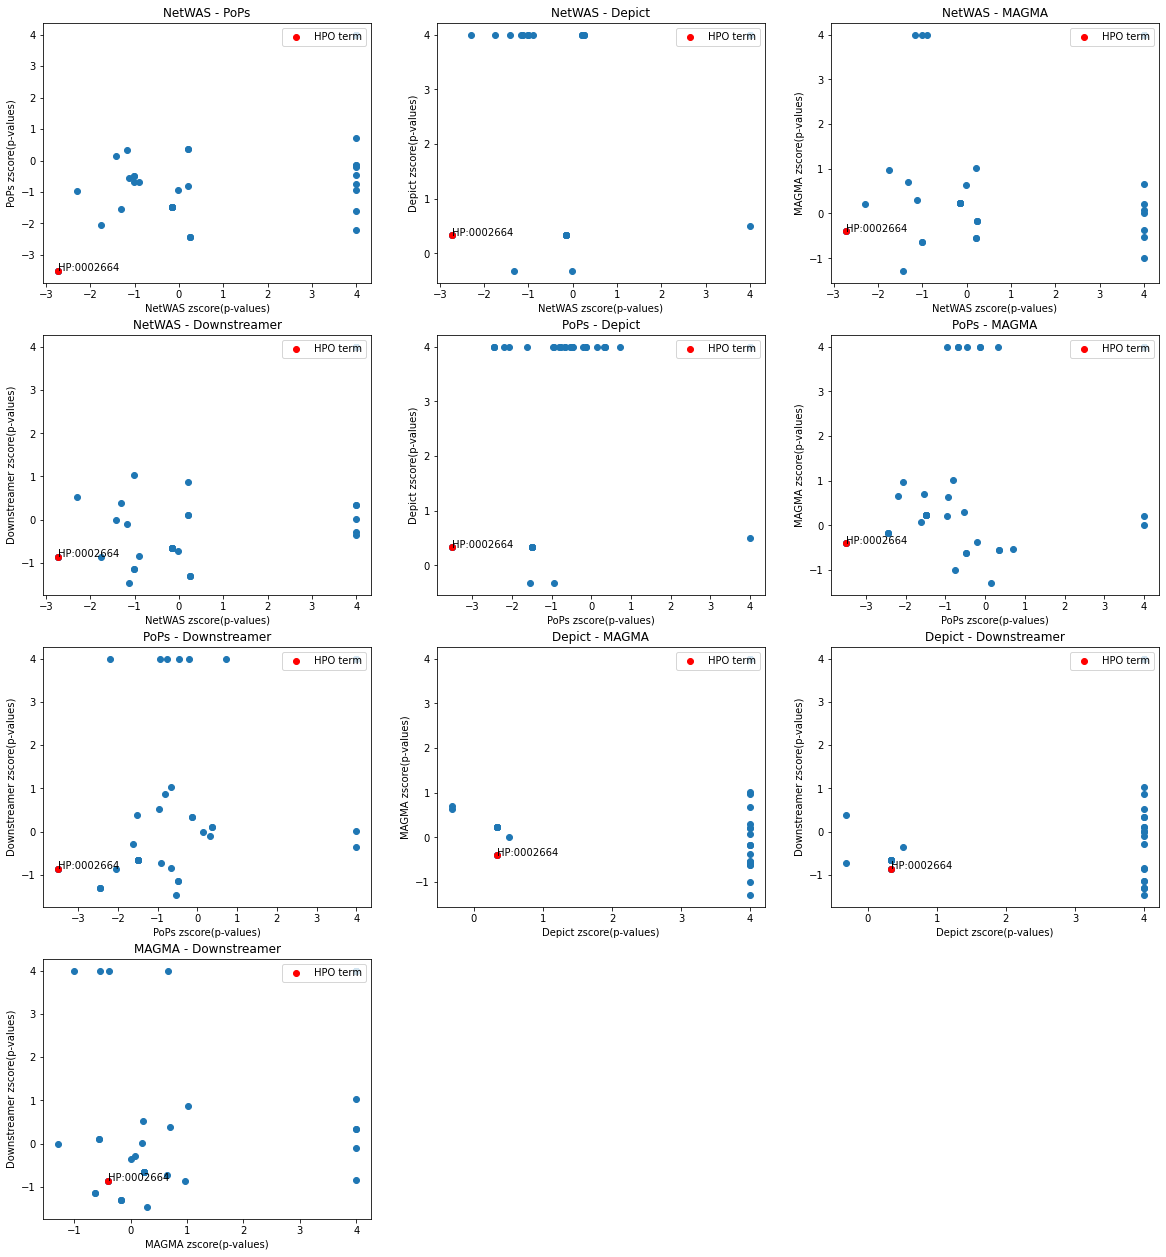

In [8]:
plot_comparison_fisher_results(results_fisher['PrC'], "Prostate cancer")

# Compare the gene scores of different gene prioritization methods

Every method prioritizes a gene differently and here we would like to compare the methods in a general way by looking at what score each method gave to the same genes. 

In [9]:
# HPO = r"C:\Users\stijn\Documents\Master_DSLS\Semester_two\project\HPO\phenotype_to_genes_V1268_OMIMandORPHA.txt_matrix.txt.gz"
HPO = config["hpo_data"]
hpo_data = pd.read_csv(HPO, compression='gzip', sep="\t")
hpo_data.set_index('-', inplace=True)
hpo_data.head(5)

,HP:0001187,HP:0009902,HP:0025152,HP:0009905,HP:0009904,HP:0001188,HP:0009907,HP:0025158,HP:0001182,HP:0009906,...,HP:0000558,HP:0001889,HP:0000553,HP:0001884,HP:0001883,HP:0000552,HP:0000555,HP:0001886,HP:0000554,HP:0001885
-,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def read_netwas(data):
    """
    Read in data from a CSV file generated by NetWAS.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    netwas_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    netwas_data = pd.read_csv(data, sep=",")
    return netwas_data, netwas_data[["ensemble_id", "netwas_score"]]


def read_pops(data):
    """
    Read in data from a CSV file generated by PoPs.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    pops_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    pops_data = pd.read_csv(data, sep="\t")
    return pops_data, pops_data[["ENSGID", "PoPS_Score"]]


def read_downstreamer(data):
    """
    Read in data from a excel file generated by Downstreamer.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    downstreamer_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    downstreamer_data = pd.read_excel(data, "GenePrioritization")
    return downstreamer_data, downstreamer_data[["Gene ID", "Enrichment Z-score"]]

def read_magma(data):
    """
    Read in data from a CSV file generated by MAGMA.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    magma_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    magma_data = pd.read_csv(data, sep='\s\s+', engine='python')
    return magma_data, magma_data[["GENE", "ZSTAT"]]


def read_depict(data):
    """
    Read in data from a CSV file generated by DEPICT.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    depict_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    depict_data = pd.read_csv(data, sep="\t")
    depict_data.columns = depict_data.columns.str.rstrip()
    depict_data["Ensembl Gene ID"] = depict_data["Ensembl Gene ID"].str.rstrip()
    depict_data["zscores"] = stats.zscore(depict_data["Nominal P value"], nan_policy='omit')
    return depict_data, depict_data[["Ensembl Gene ID", "zscores"]]

In [11]:
read_data = {"NetWAS": read_netwas, "PoPs": read_pops, "MAGMA": read_magma, 
             "Depict": read_depict, "Downstreamer": read_downstreamer}


results_methods = {}

gene_score_methods = {}

for trait, info in config["results_methods"].items():
    results_methods[trait] = {}
    gene_score_methods[trait] = []
    for method, file in info.items():
        data, gene_scores = read_data[method](file)
        results_methods[trait][method] = {'data':data, "genes":gene_scores.iloc[:,0]}
        gene_score_methods[trait].append((method, gene_scores))

C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
def plot_score_comparison(trait_data, hpo_data, hpo_term, trait) -> None:
    """
    There are several gene prioritization method each with their own way of "prioritizing" genes.
    This function compares the 'scores' each method gave to the genes.
    
    :parameters
    -----------
    trait_data - list<tuple>
        A list with tuples containing the name of the gene prioritization method and their results
        for a specific trait (e.g. height, IBD, or prostate cancer)
    hpo_data - pd.DataFrame
        Dataframe containing the HPO data
    hpo_term - str
        Relevant HPO term for the GWAS trait that was used.
        example: GWAS trait = height, hpo term = HP:0000002 (skeletal abnormalities)
    trait - str
        Name of the GWAS trait that was originally used.
    """
    plt.figure(figsize=(20, 18))

    hpo_term_genes = hpo_data.index[hpo_data[hpo_term] == 1].values

    for i, (method1, method2) in enumerate(combinations(trait_data,2)):
        plt.subplot(4, 3, i+1)
        # Take the overlap between two methods
        overlap = method1[1].iloc[:, 0].isin(method2[1].iloc[:, 0])
        # Filter the first method based on that overlap 
        method1_overlap = method1[1].loc[overlap, :]

        # Filter the second method based on that overlap 
        method2_overlap = method2[1][method2[1].iloc[:, 0].isin(method1_overlap.iloc[:, 0])]
        hpo_genes = method2_overlap.iloc[:, 0].isin(hpo_term_genes)

        # Sort the two data frames -> same order of genes
        method1_overlap.sort_values(method1_overlap.columns[0], ascending = False, inplace=True)


        method2_overlap.sort_values(method2_overlap.columns[0], ascending = False, inplace=True)

        x = method1_overlap.loc[~hpo_genes.values].iloc[:, 1]
        x_hpo = method1_overlap.loc[hpo_genes.values].iloc[:, 1]
        
        y = method2_overlap.loc[~hpo_genes.values].iloc[:, 1]
        y_hpo = method2_overlap.loc[hpo_genes.values].iloc[:, 1]
        
        corr, _ = pearsonr(x, y)

        plt.scatter(x, y, alpha=0.5, label="Genes")
        plt.scatter(x_hpo, y_hpo, alpha=0.3, label="HPO term genes")

        plt.text(plt.xlim()[0], plt.ylim()[1] ,np.round(corr, 2))
        diag_line, = plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")

        plt.xlabel(f"{method1[0]} score"); plt.ylabel(f"{method2[0]} score")
        plt.legend(loc="upper right")

    plt.show()

C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method1_overlap.sort_values(method1_overlap.columns[0], ascending = False, inplace=True)
C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method2_overlap.sort_values(method2_overlap.columns[0], ascending = False, inplace=True)


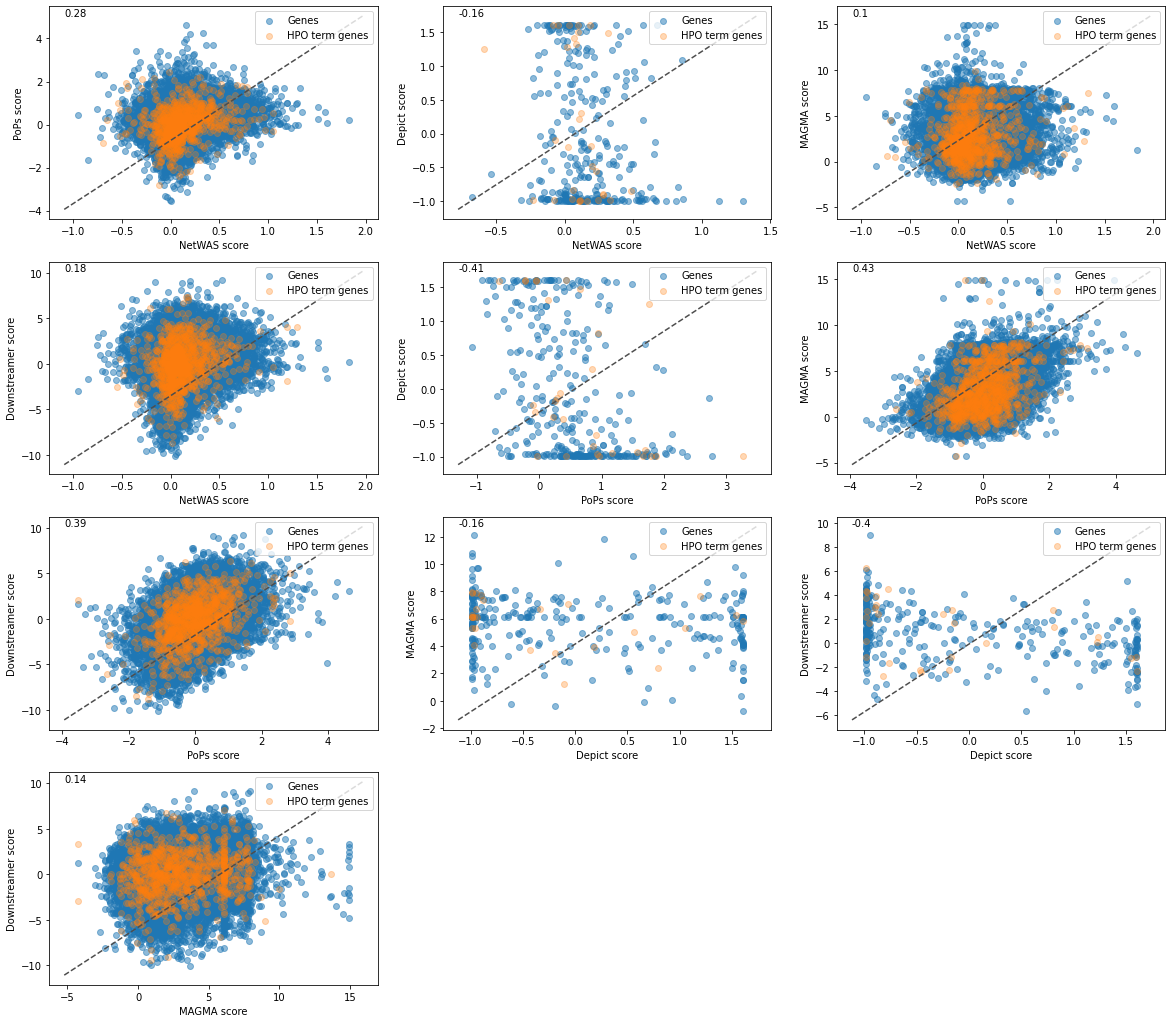

In [13]:
height_hpo = 'HP:0000002'
plot_score_comparison(trait_data=gene_score_methods["Height"], hpo_data=hpo_data, hpo_term=height_hpo, trait="Height")

C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method1_overlap.sort_values(method1_overlap.columns[0], ascending = False, inplace=True)
C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method2_overlap.sort_values(method2_overlap.columns[0], ascending = False, inplace=True)


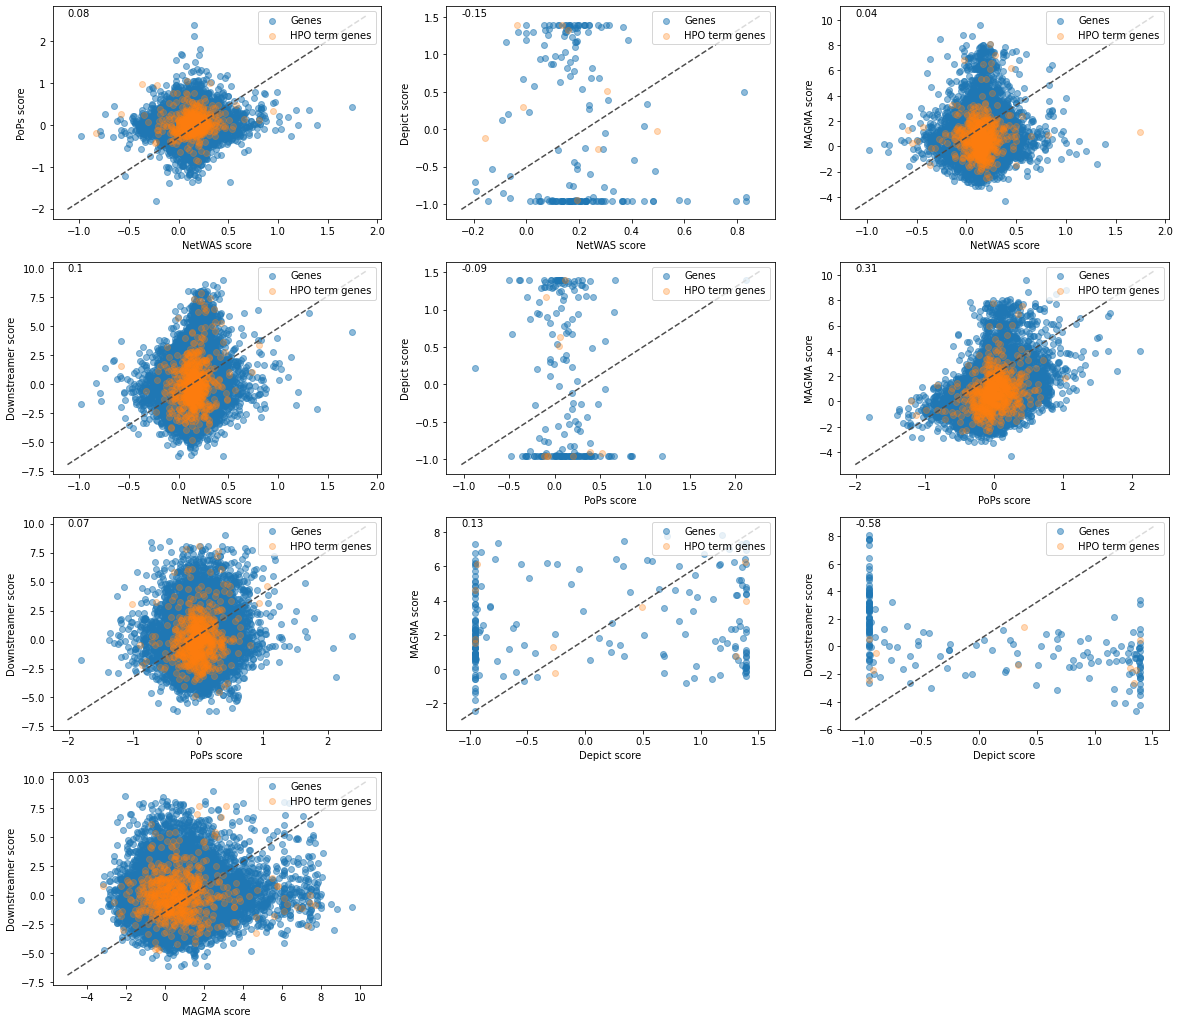

In [14]:

ibd_hpo = 'HP:0012649'
plot_score_comparison(trait_data=gene_score_methods["IBD"], hpo_data=hpo_data, hpo_term=ibd_hpo, trait="IBD")

C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method1_overlap.sort_values(method1_overlap.columns[0], ascending = False, inplace=True)
C:\Users\stijn\AppData\Local\Temp\ipykernel_3152\3548254066.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method2_overlap.sort_values(method2_overlap.columns[0], ascending = False, inplace=True)


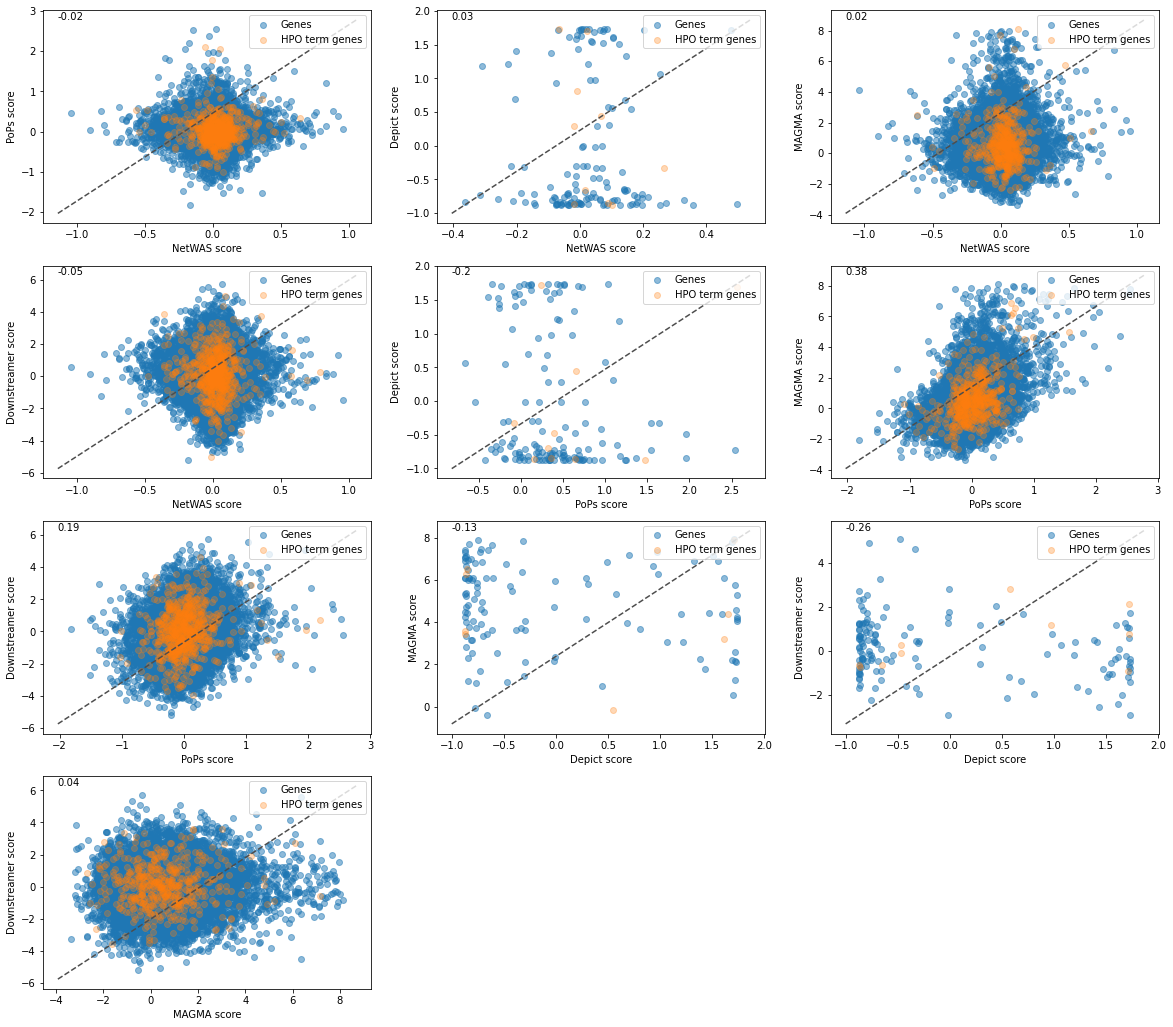

In [15]:
prc_hpo = 'HP:0002664'
plot_score_comparison(trait_data=gene_score_methods["PrC"], hpo_data=hpo_data, hpo_term=prc_hpo, trait="PrC")

# Calculate and plot the percentage of prioritized genes that overlap with a related HPO term

>NOTE we are supposed to take only the significant genes

In [16]:
def get_overlap_hpo(hpo_data, genes):
    """
    Get the genes overlapping with the HPO database.

    :parameters
    -----------
    hpo_data - pd.DataFrame
        HPO data inside a pandas dataframe
    genes - pd.Series
        Series of gene IDs

    :returns
    --------
    overlap_hpo - pd.DataFrame
        HPO data overlapping with the supplied genes
    overlap_genes - pd.Series
        Genes overlapping with the HPO data
    """
    overlapping_genes_data = hpo_data[hpo_data.index.isin(genes)]
    overlapping_genes = overlapping_genes_data.index

    # Only keep the genes that overlap with HPO
    overlap_genes = genes[genes.isin(overlapping_genes)]

    # Only keep releveant HPO data
    overlap_hpo = hpo_data[hpo_data.index.isin(overlapping_genes)]
    return overlap_hpo, overlap_genes

In [17]:
def get_overlap_genes_netwas(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_netwas - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_netwas = data[data.ensemble_id.isin(genes)]
    return overlap_netwas

def get_overlap_genes_pops(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_pops - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_pops = data[data["ENSGID"].isin(genes)]
    return overlap_pops

def get_overlap_genes_depict(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_depict - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_depict = data[data["Ensembl Gene ID"].isin(genes)]
    return overlap_depict

def get_overlap_genes_downstreamer(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_downstreamer - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_downstreamer = data[data["Gene ID"].isin(genes)]
    return overlap_downstreamer

def get_overlap_genes_magma(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_magma - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_magma = data[data["GENE"].isin(genes)]
    return overlap_magma

In [18]:
def filter_netwas(data, threshold=0.5):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_netwas - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_netwas = data[data.netwas_score > threshold]
    significant_genes = significant_netwas.ensemble_id
    return significant_netwas, significant_genes

def filter_pops(data, threshold=500):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_pops - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_pops = data.sort_values("PoPS_Score", ascending=False).iloc[0:threshold, :]
    significant_genes = significant_pops["ENSGID"]
    return significant_pops, significant_genes


def filter_depict(data, threshold = None):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_depict - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_depict = data[data["False discovery rate < 5%"] == "Yes"]
    significant_genes = significant_depict["Ensembl Gene ID"]
    return significant_depict, significant_genes



def filter_downstreamer(data, threshold = None):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_downstreamer - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_downstreamer = data[data["FDR 5% significant"] == True]
    significant_genes = significant_downstreamer["Gene ID"]
    return significant_downstreamer, significant_genes


def filter_magma(data, threshold=1.084e-4):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what gene is significant.

    :returns
    --------
    significant_mamga - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_magma = data[data["P"] < threshold]
    significant_genes = significant_magma["GENE"]
    return significant_magma, significant_genes

In [19]:
def calculate_percentage_overlap(genes, hpo_data, hpo_term):
    """
    Calculate the percentage of overlap from a list of genes
    and a list of genes for a specific HPO term.
    
    :parameters
    -----------
    genes - pd.Series
        A list of ensembl IDs
    hpo_data - pd.DataFrame
        HPO data inside a pandas dataframe
    hpo_term - str
        Relevant HPO term for the GWAS trait that was used.
        example: GWAS trait = height, hpo term = HP:0000002 (skeletal abnormalities)
        
    :returns
    --------
    percentage_overlap - float
        The total overlap in percentage
    """
    total = len(genes)
    hpo_genes = hpo_data[hpo_data[hpo_term] == 1].index
    n_overlap = genes.isin(hpo_genes).sum()

    percentage_overlap = np.round((n_overlap / total) * 100, 2)

    return percentage_overlap


def add_labels(x,y, addition="") -> None:
    """
    Support function that adds the value of y
    to the plot on each position (x, y).
    
    :parameters
    -----------
    x - list
        List of x values
    y - list
        list of y values
    addition - str
        Text to be added after the y value. (default = '')
    """
    for i in range(len(x)):
        plt.text(i, y[i], str(np.round(y[i], 2)) + addition, ha = 'center')

def plot_compare_overlap(methods, perc_overlap, hpo_term, figsize=(10, 5)) -> None:
    """
    Plot the percentage of genes prioritized by a gene prioritization method
    that overlapped with the genes from the HPO term of interest. 
    
    :parameters
    -----------
    methods - list
        Name of the gene prioritization methods
    perc_overlap - list
        List containing the percentage of overlapping genes for each method
    hpo_term - str
        Relevant HPO term for the GWAS trait that was used.
        example: GWAS trait = height, hpo term = HP:0000002 (skeletal abnormalities)
    fig_size - tuple
        The size of the figure. default = (10, 5)
    """
    fig = plt.figure(figsize = figsize)

    # Sort from highest to lowest
    sorted_index = np.argsort(perc_overlap)[::-1]
    perc_overlap = np.array(perc_overlap)[sorted_index]
    methods = np.array(methods)[sorted_index]

    # creating the bar plot
    plt.bar(methods, perc_overlap, color="dimgrey",
            width = 0.4)
    
    add_labels(methods, perc_overlap, addition="%")

    plt.xlabel("Gene prioritization methods")
    plt.ylabel("% Prioritized genes")
    plt.title(f"The percentage of prioritized genes overlapping with HPO related to {hpo_term}")
    plt.show()

In [20]:
filter_data = {"NetWAS": filter_netwas, "PoPs": filter_pops, "MAGMA": filter_magma, 
             "Depict": filter_depict, "Downstreamer": filter_downstreamer}

get_overlap_genes = {"NetWAS": get_overlap_genes_netwas, "PoPs": get_overlap_genes_pops, "MAGMA": get_overlap_genes_magma, 
             "Depict": get_overlap_genes_depict, "Downstreamer": get_overlap_genes_downstreamer}

In [21]:
height_perc_overlap = {}

data_per_method = {}

for method, data in results_methods["Height"].items():
    overlap_hpo, overlap_genes = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data = get_overlap_genes[method](data["data"], overlap_genes)
    
    sign_data, sign_genes = filter_data[method](overlapping_data)
    
    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"])
    
    percentage = calculate_percentage_overlap(sign_genes, hpo_data, height_hpo)
    height_perc_overlap[method] = percentage

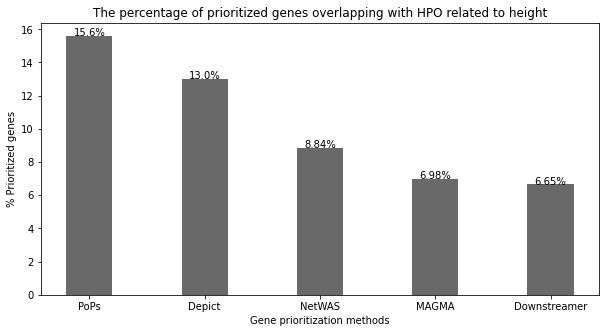

In [22]:
methods = list(height_perc_overlap.keys())
vals = list(height_perc_overlap.values())
    
plot_compare_overlap(methods, vals, "height")

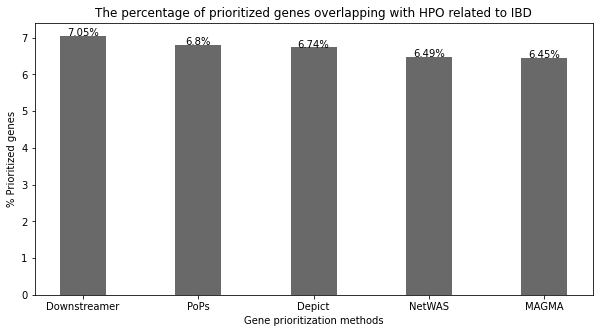

In [23]:
ibd_perc_overlap = {}

for method, data in results_methods["IBD"].items():
    overlap_hpo, overlap_genes = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data = get_overlap_genes[method](data["data"], overlap_genes)
    
    sign_data, sign_genes = filter_data[method](overlapping_data)
    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"]) # sign_data
    percentage = calculate_percentage_overlap(sign_genes, hpo_data, ibd_hpo)
    ibd_perc_overlap[method] = percentage
    
methods = list(ibd_perc_overlap.keys())
vals = list(ibd_perc_overlap.values())
    
plot_compare_overlap(methods, vals, "IBD")

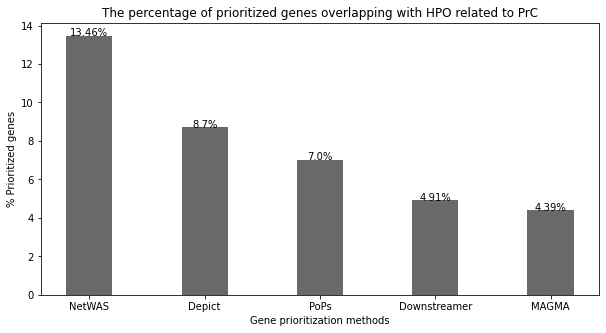

In [24]:
prc_perc_overlap = {}

for method, data in results_methods["PrC"].items():
    overlap_hpo, overlap_genes = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data = get_overlap_genes[method](data["data"], overlap_genes)
    
    sign_data, sign_genes = filter_data[method](overlapping_data)
    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"]) # sign_data
    percentage = calculate_percentage_overlap(sign_genes, hpo_data, prc_hpo)
    prc_perc_overlap[method] = percentage
    
methods = list(prc_perc_overlap.keys())
vals = list(prc_perc_overlap.values())
    
plot_compare_overlap(methods, vals, "PrC")

# Percentage of overlapping genes from the top 500 prioritized genes.

In [25]:
def calculate_percentage_overlap_methods(genes_one, genes_two):
    """
    Calculate the percentage of overlap from two list of genes
    both from a seperate gene prioritization method.
    
    :parameters
    -----------
    genes_one - pd.Series
        A list of ensembl IDs from a gene prioritization method
    genes_two - pd.Series
        A list of ensembl IDs from another gene prioritization method
        
    :returns
    --------
    percentage_overlap - float
        The total overlap in percentage
    """
    # Take the top 500 genes instead
    if genes_one.shape[0] < genes_two.shape[0]:
        n_genes = genes_one.shape[0]
    else:
        n_genes = genes_two.shape[0]
    n_overlap = genes_one.isin(genes_two).sum()
    percentage_overlap = np.round((n_overlap / n_genes) * 100, 2)
    return percentage_overlap

In [26]:
def select_genes_netwas(data, n_genes=500):
    """
    Select the top n (default=500) genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    n_genes - int
        number of genes to select.

    :returns
    --------
    top_n_genes - pd.Series
        Gene IDs of top n genes
    """
    return data.iloc[0:n_genes, 1]

def select_genes_pops(data, n_genes=500):
    """
    Select the top n (default=500) genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    n_genes - int
        number of genes to select.

    :returns
    --------
    top_n_genes - pd.Series
        Gene IDs of top n genes
    """
    return data.sort_values("PoPS_Score", ascending=False).iloc[0:n_genes, 0]


def select_genes_depict(data, n_genes=500):
    """
    Select the top n (default=500) genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    n_genes - int
        number of genes to select.

    :returns
    --------
    top_n_genes - pd.Series
        Gene IDs of top n genes
    """
    return data.sort_values("Nominal P value").iloc[0:n_genes, 3]



def select_genes_downstreamer(data, n_genes = 500):
    """
    Select the top n (default=500) genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    n_genes - int
        number of genes to select.

    :returns
    --------
    top_n_genes - pd.Series
        Gene IDs of top n genes
    """
    return data.sort_values("Enrichment P-value").iloc[0:n_genes, 0]


def select_genes_magma(data, n_genes=500):
    """
    Select the top n (default=500) genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    n_genes - int
        number of genes to select

    :returns
    --------
    top_n_genes - pd.Series
        Gene IDs of top n genes
    """
    return data.sort_values("P").iloc[0:n_genes, 0]

In [27]:
get_top_genes = {"NetWAS": select_genes_netwas, "PoPs": select_genes_pops, "MAGMA": select_genes_magma, 
             "Depict": select_genes_depict, "Downstreamer": select_genes_downstreamer}

top_genes_methods = []

for method, data in data_per_method.items():
    top_genes_all = []
    for df in data:
        top_genes_all.append(get_top_genes[method](df))
        
    top_genes_methods.append((method, top_genes_all))

In [28]:
barplot_overlap = pd.DataFrame(columns = ["methods", "height", "IBD", "PrC"])

# Calculate the overlap between each method for the three traits: height, IBD and prostate cancer

for i, (method1, method2) in enumerate(combinations(top_genes_methods,2)):
    methods = f"{method1[0]} - {method2[0]}"
    n_overlap_height = calculate_percentage_overlap_methods(method1[1][0], method2[1][0])
    n_overlap_ibd = calculate_percentage_overlap_methods(method1[1][1], method2[1][1])
    n_overlap_prostate = calculate_percentage_overlap_methods(method1[1][2], method2[1][2])
    print(f"Overlap {method1[0]} - {method2[0]}: {n_overlap_height}%, {n_overlap_ibd}%, {n_overlap_prostate}%")
    barplot_overlap.loc[len(barplot_overlap)] = [methods, n_overlap_height, n_overlap_ibd, n_overlap_prostate]

Overlap NetWAS - PoPs: 5.4%, 5.0%, 3.6%
Overlap NetWAS - Depict: 2.79%, 6.51%, 4.68%
Overlap NetWAS - MAGMA: 2.0%, 3.6%, 4.2%
Overlap NetWAS - Downstreamer: 0.8%, 5.0%, 1.0%
Overlap PoPs - Depict: 9.39%, 6.51%, 23.98%
Overlap PoPs - MAGMA: 15.0%, 13.0%, 19.6%
Overlap PoPs - Downstreamer: 4.8%, 12.2%, 5.2%
Overlap Depict - MAGMA: 9.14%, 30.23%, 52.63%
Overlap Depict - Downstreamer: 1.27%, 6.51%, 2.34%
Overlap MAGMA - Downstreamer: 1.2%, 6.4%, 3.8%


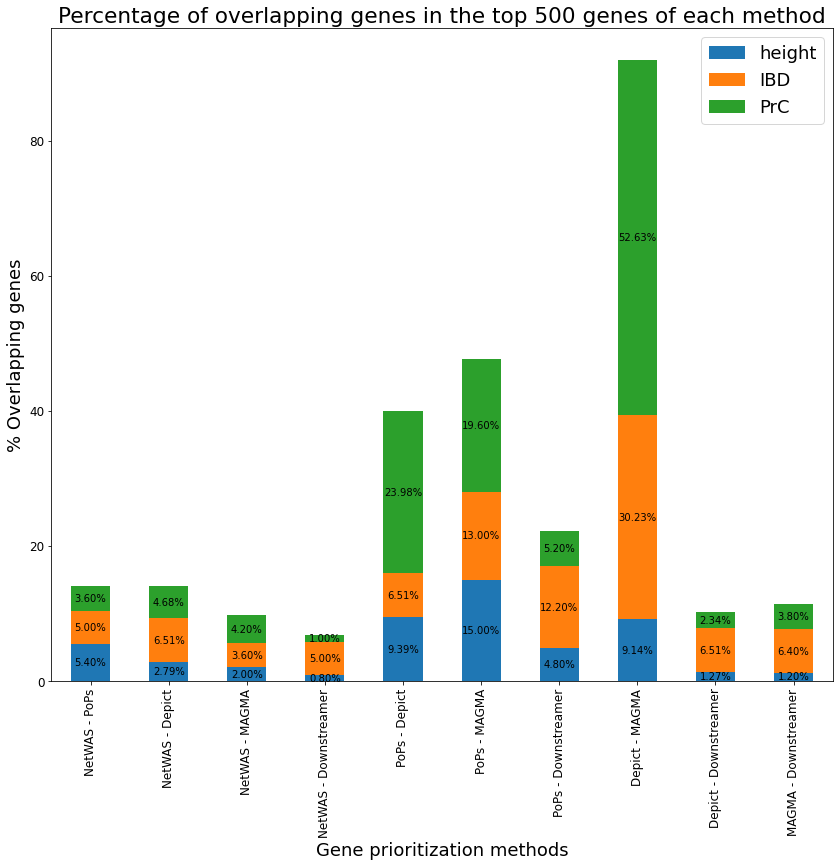

In [29]:
def plot_stacked_bar(df, x, title, xlabel, ylabel, figsize=(14, 12)) -> None:
    """
    Plot a stacked barplot from a pandas data frame.
    
    :parameters
    -----------
    df - pd.DataFrame
        The dataframe must be designed in such a way that it can be used to create a stacked bar plot
    x - str
        Name of the column to group the data on
    title - str
        Title of the plot
    xlabel - str
        Label for on the x-axis
    ylabel - str
        Label for on the y-axis
    figsize - tuple
        Size of the figure. default = (14, 12)
    """
    plt.rcParams.update({'font.size': 18}) # must set in top

    ax = df.plot(x='methods', kind='bar', stacked=True,
            title=title, figsize=figsize,
                             xlabel=xlabel, 
                              ylabel=ylabel, fontsize=12)

    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.2f}%'

        label_x = x + width / 2
        label_y = y + height / 2

        # Only plot when either on of them is above 0
        if height > 0.0 or y > 0.0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)

    plt.style.use('default')
    plt.show()
    
plot_stacked_bar(barplot_overlap, 'methods', title='Percentage of overlapping genes in the top 500 genes of each method',
                xlabel="Gene prioritization methods", ylabel="% Overlapping genes")